Continuation of Clustering script!

In [1]:
import sys
sys.path.append('./scripts/')
import os
import matplotlib.pyplot as plt
import seaborn as sns
import math
import glob
import numpy as np
sns.set_style("darkgrid")
from PIL import Image

import torch
import torchvision

from captum.concept import TCAV
from captum.concept import Concept
from captum.concept._utils.data_iterator import dataset_to_dataloader, CustomIterableDataset
from captum.concept._utils.common import concepts_to_str

import imp
import my_datasets
import utilities 
imp.reload(my_datasets) 
imp.reload(utilities) 

plt.rcParams["figure.figsize"] = (3,3)

/tmp/ipykernel_52630/2735287361.py:20: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  import imp


In [2]:
dataset='ilsvrc12fine'
paths, count, y, idx_to_labels = my_datasets.get_dataset(dataset)

print(count, len(paths))

1281167 1281167


In [3]:
layer='Mixed_7b.cat_2'
SAVEFOLD0=f'../outputs/{dataset}'
SAVEFOLD=f"{SAVEFOLD0}/{layer}/"

In [4]:
neuron = 35
folder = f'{SAVEFOLD}concept_ims_neuron_{neuron}/top_ims/'

## Utilities

In [5]:
transform = torchvision.transforms.Compose([
 torchvision.transforms.Resize(299),
 torchvision.transforms.CenterCrop(299),
 torchvision.transforms.ToTensor()
])

transform_normalize = torchvision.transforms.Normalize(
     mean=[0.485, 0.456, 0.406],
     std=[0.229, 0.224, 0.225]
 )

In [6]:
def assemble_concept(name, id, concepts_path):
    concept_path = os.path.join(concepts_path, name) + "/"
    dataset = CustomIterableDataset(get_tensor_from_filename, concept_path)
    concept_iter = dataset_to_dataloader(dataset)

    return Concept(id=id, name=name, data_iter=concept_iter)

In [7]:
def get_tensor_from_filename(filename):
    img = Image.open(filename).convert("RGB")
    return transform(img)

In [8]:
concepts_path = f'{SAVEFOLD}concept_ims_neuron_{neuron}/'

i=0
concepts = []
while os.path.exists(f'{concepts_path}/cluster_{i}'):
    concepts.append(assemble_concept(f"cluster_{i}", i, concepts_path=concepts_path) )
    i+=1
j=0
randoms = []
while os.path.exists(f'{concepts_path}/random_{j}'):
    randoms.append(assemble_concept(f"random_{j}", i, concepts_path=concepts_path) )
    i+=1
    j+=1

In [9]:
# concepts_path = f'{SAVEFOLD}concept_ims_neuron_{neuron}/'

# cl0_concept = assemble_concept("cluster_0", 0, concepts_path=concepts_path)
# cl1_concept = assemble_concept("cluster_1", 1, concepts_path=concepts_path)

# rand0_concept = assemble_concept("random_0", 2, concepts_path=concepts_path)
# rand1_concept = assemble_concept("random_1", 3, concepts_path=concepts_path)

In [ ]:
n_figs = 5
n_concepts = len(concepts+randoms)

fig, axs = plt.subplots(n_concepts, n_figs + 1, figsize = (25, 4 * n_concepts))

for c, concept in enumerate(concepts+randoms ): # [cl0_concept, cl1_concept, rand0_concept, rand1_concept]
    concept_path = os.path.join(concepts_path, concept.name) + "/"
    img_files = glob.glob(concept_path + '*')
    for i, img_file in enumerate(img_files[:n_figs + 1]):
        if os.path.isfile(img_file):
            if i == 0:
                axs[c, i].text(1.0, 0.5, str(concept.name), ha='right', va='center', family='sans-serif', size=24)
            else:
                img = plt.imread(img_file)
                axs[c, i].imshow(img)

            axs[c, i].axis('off')

In [11]:
model = torch.hub.load('pytorch/vision:v0.9.0', 'inception_v3', pretrained=True)
model.eval()

Using cache found in /home/laura/.cache/torch/hub/pytorch_vision_v0.9.0
/home/laura/anaconda3/envs/sw-interpretability/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/laura/anaconda3/envs/sw-interpretability/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [12]:
from captum.attr import LayerGradientXActivation, LayerIntegratedGradients

mytcav = TCAV(model=model,
              layers=['Mixed_7b'],
#               layers=['Mixed_7b.branch1x1.conv',
#                       'Mixed_7b.branch3x3_2a.conv','Mixed_7b.branch3x3_2b.conv',
#                       'Mixed_7b.branch3x3dbl_3a.conv','Mixed_7b.branch3x3dbl_3b.conv',
#                       'Mixed_7b.branch_pool.conv'],
              layer_attr_method = LayerIntegratedGradients(
                model, None, multiply_by_inputs=False), 
              save_path=f'{SAVEFOLD}concept_ims_neuron_{neuron}/cav')

/home/laura/sw-interpretability/src/captum/captum/concept/_utils/classifier.py:130: UserWarning: Using default classifier for TCAV which keeps input both train and test datasets in the memory. Consider defining your own classifier that doesn't rely heavily on memory, for large number of concepts, by extending `Classifer` abstract class
  warnings.warn(


In [13]:
# experimental_set_rand = [[cl0_concept, rand0_concept], [cl1_concept, rand1_concept]]
experimental_set_rand = []
for i in range(len(concepts)):
    experimental_set_rand.append([concepts[i], randoms[i]] )

In [14]:
# Load sample images from folder
def load_image_tensors(root_path=f'{SAVEFOLD}concept_ims_neuron_{neuron}/top_ims/', transform=True):
    path = os.path.join(root_path)
    filenames = glob.glob(path + '/*.JPEG')

    tensors = []
    for filename in filenames:
        #print(filename)
        img = Image.open(filename).convert('RGB')
        tensors.append(transform(img) if transform else img) ### doesn't work if transform= True
    
    return tensors
top_ims_test = load_image_tensors(transform=False)

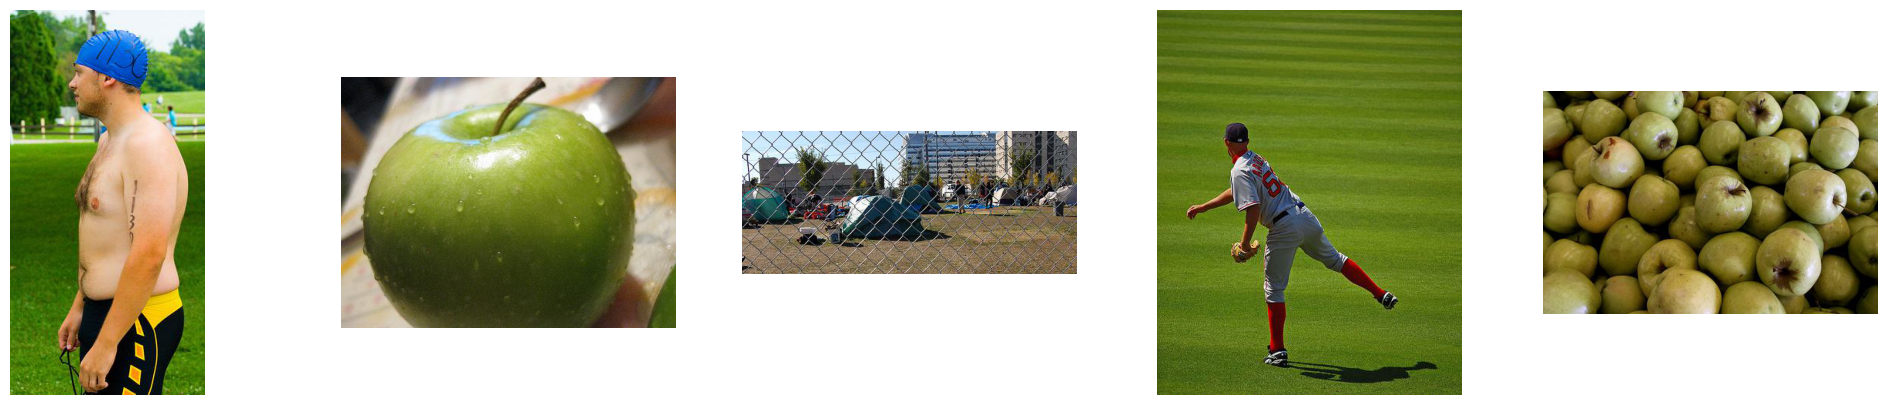

In [15]:
fig, axs = plt.subplots(1, 5, figsize = (25, 5))
axs[0].imshow(top_ims_test[0])
axs[1].imshow(top_ims_test[1])
axs[2].imshow(top_ims_test[2])
axs[3].imshow(top_ims_test[3])
axs[4].imshow(top_ims_test[4])

axs[0].axis('off')
axs[1].axis('off')
axs[2].axis('off')
axs[3].axis('off')
axs[4].axis('off')

plt.show()

In [16]:
cavs_35 = mytcav.compute_cavs(experimental_set_rand)

In [17]:
cavs_35

defaultdict(<function captum.concept._core.tcav.TCAV.__init__.<locals>.<lambda>()>,
            {'0-3': defaultdict(None,
                         {'Mixed_7b': <captum.concept._core.cav.CAV at 0x7f668f945f70>}),
             '1-4': defaultdict(None,
                         {'Mixed_7b': <captum.concept._core.cav.CAV at 0x7f668fa84040>}),
             '2-5': defaultdict(None,
                         {'Mixed_7b': <captum.concept._core.cav.CAV at 0x7f668fabcac0>})})

In [18]:
cavs_35['0-3']['Mixed_7b']

https://captum.ai/api/concept.html

generate_activations(concept_layers)

generate_activations(concept_layers)

generate_all_activations()

load_cavs(concepts)

In [19]:
#  Load sample images from folder
# top_ims_tensors = torch.stack([transform_normalize(transform(img)) for img in top_ims_test[:5]])
# experimental_set_rand

In [20]:
# tcav_scores_w_random = mytcav.interpret(inputs=top_ims_tensors,
#                                         experimental_sets=experimental_set_rand,
#                                         #target=zebra_ind,
#                                         n_steps=5,
#                                        )
# tcav_scores_w_random

In [21]:
from captum.concept import ConceptInterpreter
ConceptInterpreter(model)

In [22]:
#import pickle
with open(f'{SAVEFOLD}concept_ims_neuron_{neuron}/cav/default_model_id/0-3-Mixed_7b.pkl', 'rb') as f:
    concept_0 = torch.load(f)
with open(f'{SAVEFOLD}concept_ims_neuron_{neuron}/cav/default_model_id/1-4-Mixed_7b.pkl', 'rb') as f:
    concept_1 = torch.load(f)
with open(f'{SAVEFOLD}concept_ims_neuron_{neuron}/cav/default_model_id/2-5-Mixed_7b.pkl', 'rb') as f:
    concept_2 = torch.load(f)

In [23]:
print("concept_0", concept_0)
print("\nconcept_0['stats']", concept_0['stats'])
print("\nconcept_0['stats']['weights']: ", concept_0['stats']['weights'])

concept_0 {'concept_ids': [0, 3], 'concept_names': ['cluster_0', 'random_0'], 'layer': 'Mixed_7b', 'stats': {'weights': tensor([[ 0.1064, -0.0000, -0.0381,  ..., -0.0279,  0.0511,  0.0293],
        [-0.1064,  0.0000,  0.0381,  ...,  0.0279, -0.0511, -0.0293]]), 'classes': array([0, 3], dtype=int32), 'accs': tensor(0.5385)}}

concept_0['stats'] {'weights': tensor([[ 0.1064, -0.0000, -0.0381,  ..., -0.0279,  0.0511,  0.0293],
        [-0.1064,  0.0000,  0.0381,  ...,  0.0279, -0.0511, -0.0293]]), 'classes': array([0, 3], dtype=int32), 'accs': tensor(0.5385)}

concept_0['stats']['weights']:  tensor([[ 0.1064, -0.0000, -0.0381,  ..., -0.0279,  0.0511,  0.0293],
        [-0.1064,  0.0000,  0.0381,  ...,  0.0279, -0.0511, -0.0293]])


In [24]:
print("concept_1", concept_1)
print("\nconcept_1['stats']", concept_1['stats'])
print("\nconcept_1['stats']['weights']: ", concept_1['stats']['weights'])

concept_1 {'concept_ids': [1, 4], 'concept_names': ['cluster_1', 'random_1'], 'layer': 'Mixed_7b', 'stats': {'weights': tensor([[ 0.0817, -0.0000, -0.0517,  ..., -0.0000, -0.0000, -0.0000],
        [-0.0817,  0.0000,  0.0517,  ...,  0.0000,  0.0000,  0.0000]]), 'classes': array([1, 4], dtype=int32), 'accs': tensor(0.6923)}}

concept_1['stats'] {'weights': tensor([[ 0.0817, -0.0000, -0.0517,  ..., -0.0000, -0.0000, -0.0000],
        [-0.0817,  0.0000,  0.0517,  ...,  0.0000,  0.0000,  0.0000]]), 'classes': array([1, 4], dtype=int32), 'accs': tensor(0.6923)}

concept_1['stats']['weights']:  tensor([[ 0.0817, -0.0000, -0.0517,  ..., -0.0000, -0.0000, -0.0000],
        [-0.0817,  0.0000,  0.0517,  ...,  0.0000,  0.0000,  0.0000]])


In [25]:
print("concept_1", concept_2)
print("\nconcept_1['stats']", concept_2['stats'])
print("\nconcept_1['stats']['weights']: ", concept_2['stats']['weights'])

concept_1 {'concept_ids': [2, 5], 'concept_names': ['cluster_2', 'random_2'], 'layer': 'Mixed_7b', 'stats': {'weights': tensor([[-0.7782, -0.1523, -0.3177,  ..., -0.0000, -0.0000, -0.0000],
        [ 0.7782,  0.1523,  0.3177,  ...,  0.0000,  0.0000,  0.0000]]), 'classes': array([2, 5], dtype=int32), 'accs': tensor(0.3000)}}

concept_1['stats'] {'weights': tensor([[-0.7782, -0.1523, -0.3177,  ..., -0.0000, -0.0000, -0.0000],
        [ 0.7782,  0.1523,  0.3177,  ...,  0.0000,  0.0000,  0.0000]]), 'classes': array([2, 5], dtype=int32), 'accs': tensor(0.3000)}

concept_1['stats']['weights']:  tensor([[-0.7782, -0.1523, -0.3177,  ..., -0.0000, -0.0000, -0.0000],
        [ 0.7782,  0.1523,  0.3177,  ...,  0.0000,  0.0000,  0.0000]])
